In [2]:
!pip3 install scipy
import warnings
warnings.filterwarnings("ignore")


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import scipy.io
mat = scipy.io.loadmat('../train_32x32.mat')

In [4]:
import cv2

def convert_dataset_to_grayscale(dataset):
    gray_dataset = []
    for image in dataset:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_dataset.append(gray_image)
    return np.array(gray_dataset)

In [19]:
import numpy as np

X = mat['X']
y = mat['y']

X = np.transpose(X, (3, 0, 1, 2))
X_gray = convert_dataset_to_grayscale(X)/255
X = X_gray
y = y-1
X.shape,y.shape


((73257, 32, 32), (73257, 1))

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)


X_train, X_val, y_train, y_val = train_test_split( 
    X_train, y_train, test_size=int((200/9)*0.9), random_state=1) # (200/9)* 0.9 = 0.2

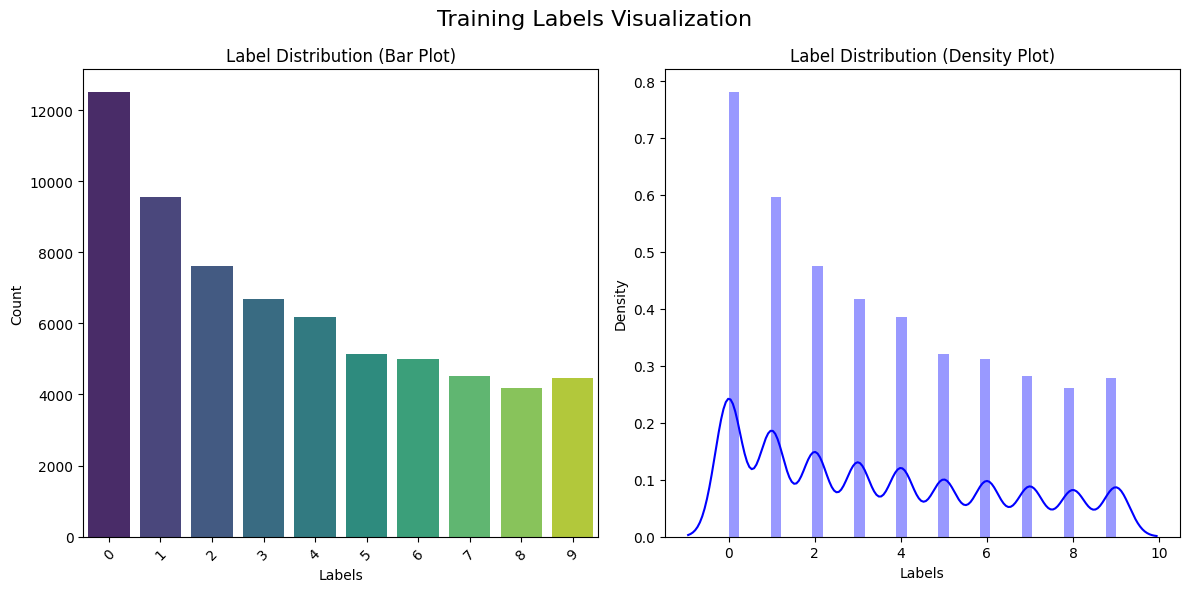

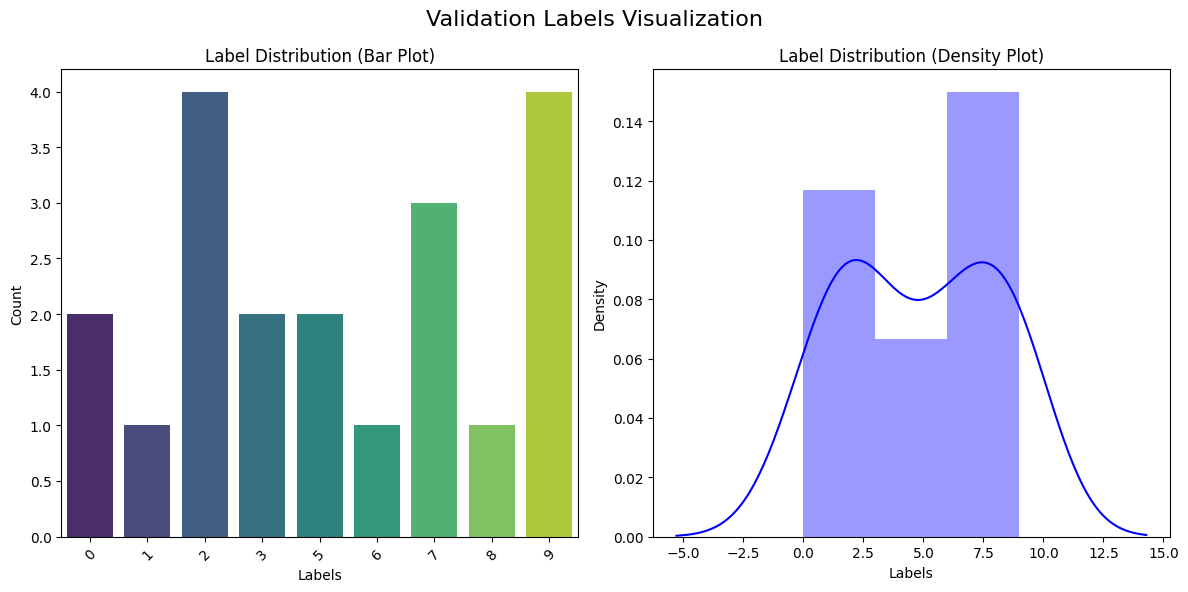

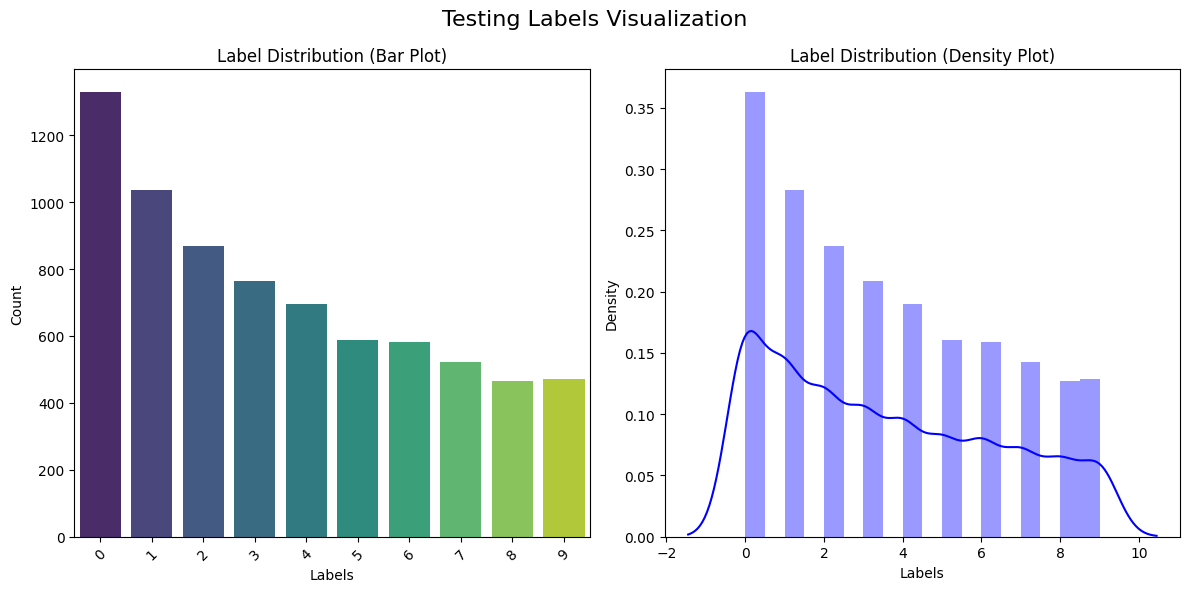

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(y,title):
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create the bar plot on the first subplot
    sns.countplot(x=y, palette='viridis', ax=axes[0])
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Label Distribution (Bar Plot)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Create the distribution plot on the second subplot
    sns.distplot(y, kde=True, color='blue', ax=axes[1])
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Label Distribution (Density Plot)')
    
    # Add a title for the entire figure
    plt.suptitle(title+' Visualization', fontsize=16)
    
    plt.tight_layout()
    plt.show()

for i in [(y_train,'Training Labels'),(y_val,'Validation Labels'),(y_test,'Testing Labels')]:
    plot_distribution(i[0].flatten(),i[1])

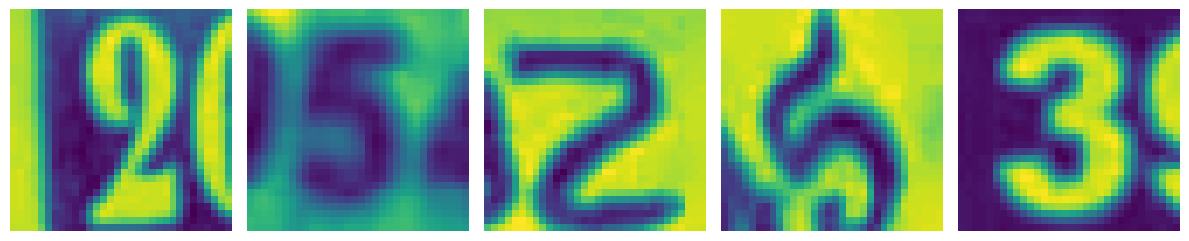

In [22]:
random_numbers = np.random.uniform(0, X_train.shape[0], 5)

fig, axes = plt.subplots(1, len(random_numbers), figsize=(12, 6))

for i, index in enumerate(random_numbers):
    ax = axes[i]
    ax.imshow(X_gray[int(index)])
    # print(y_train[int(index)])
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


### 2_a Creating Model

In [23]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1) # taken straight from the documentation

In [24]:
# from sklearn.model_selection import GridSearchCV



# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'hidden_layer_sizes': [(16, 4), (10, 5), (32,32)],  # Two hidden layers with different sizes
#     'activation': ['relu', 'tanh','logistic'],
#     'solver': ['adam', 'sgd'],
#     'batch_size': [16, 32, 64],
#     'max_iter': [10,100,500],
# }


# # Perform Grid Search to find the best hyperparameters
# grid_search = GridSearchCV(clf, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)


In [25]:
# # Training the model using ReLU activation function
# from sklearn.metrics import accuracy_score

# clf = MLPClassifier(solver='lbfgs',max_iter=1000,activation='relu',hidden_layer_sizes=(100, 50), random_state=42)
# clf.fit(X_train,y_train)

# training_loss = clf.loss_

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test[:,0],y_pred)

# print("Accuracy: ",accuracy)




In [26]:
import torch
from torch import nn
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self,X,y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        data_sample = self.data[idx]  # Get a single data sample
        label = self.labels[idx]
        return data_sample, label


training_dataset = CustomDataset(X_train,y_train)
val_dataset = CustomDataset(X_val,y_val)
test_dataset = CustomDataset(X_test,y_test)

In [27]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [28]:
# Testing cell

next(iter(train_dataloader))[0].shape

torch.Size([128, 32, 32])

In [29]:
#creating model class

class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Additional hidden layer
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, X):
        return self.layers(X)


In [30]:
model = Model(1024,100,10).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [31]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [32]:
# code for training and testing 

from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)

EPOCHS = 20

train_loss = 0

train_loss_list = []
test_loss_list = []
accuracy_list = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch : {epoch}\n------")
    for batch,(X,y) in enumerate(train_dataloader):
        
        y_pred = model(X)
        
        y  = torch.squeeze(y)
#         y = y.long()
        loss = loss_fn(y_pred, y)  
        train_loss += loss
        train_acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        if batch%520 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader)} samples.")

    train_loss /=len(train_dataloader)
    

    print(f"Training loss : {train_loss}")
    train_loss_list.append(train_loss)
    test_loss, test_acc = 0,0

    model.eval()
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            y_test = torch.squeeze(y_test)
#             y_test = y_test.long()
            test_loss+=loss_fn(test_pred,y_test)
            test_acc += accuracy_fn(y_true=y_test,y_pred = test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}| Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")
    test_loss_list.append(test_loss)
    accuracy_list.append(test_acc)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch : 0
------
Looked at 0/515 samples.


  5%|██▏                                         | 1/20 [00:02<00:45,  2.41s/it]

Training loss : 2.220474311324987
Train loss: 2.2205 | Train acc: 26.0504| Test loss : 2.1511 | Test acc : 23.7320
Epoch : 1
------
Looked at 0/515 samples.


 10%|████▍                                       | 2/20 [00:03<00:29,  1.65s/it]

Training loss : 2.0156995269110345
Train loss: 2.0157 | Train acc: 36.1345| Test loss : 1.8387 | Test acc : 34.5088
Epoch : 2
------
Looked at 0/515 samples.


 15%|██████▌                                     | 3/20 [00:04<00:23,  1.40s/it]

Training loss : 1.7140801207973075
Train loss: 1.7141 | Train acc: 50.4202| Test loss : 1.6144 | Test acc : 43.3890
Epoch : 3
------
Looked at 0/515 samples.


 20%|████████▊                                   | 4/20 [00:05<00:20,  1.29s/it]

Training loss : 1.471019638371858
Train loss: 1.4710 | Train acc: 66.3866| Test loss : 1.3333 | Test acc : 57.0232
Epoch : 4
------
Looked at 0/515 samples.


 25%|███████████                                 | 5/20 [00:06<00:18,  1.21s/it]

Training loss : 1.313869818843591
Train loss: 1.3139 | Train acc: 67.2269| Test loss : 1.2539 | Test acc : 59.3894
Epoch : 5
------
Looked at 0/515 samples.


 30%|█████████████▏                              | 6/20 [00:07<00:16,  1.18s/it]

Training loss : 1.2059795841373535
Train loss: 1.2060 | Train acc: 55.4622| Test loss : 1.1506 | Test acc : 62.4605
Epoch : 6
------
Looked at 0/515 samples.


 35%|███████████████▍                            | 7/20 [00:09<00:15,  1.16s/it]

Training loss : 1.1225609942017885
Train loss: 1.1226 | Train acc: 61.3445| Test loss : 1.0274 | Test acc : 68.8596
Epoch : 7
------
Looked at 0/515 samples.


 40%|█████████████████▌                          | 8/20 [00:10<00:13,  1.13s/it]

Training loss : 1.0588637976646835
Train loss: 1.0589 | Train acc: 72.2689| Test loss : 0.9732 | Test acc : 69.5402
Epoch : 8
------
Looked at 0/515 samples.


 45%|███████████████████▊                        | 9/20 [00:11<00:12,  1.13s/it]

Training loss : 0.9935222826090012
Train loss: 0.9935 | Train acc: 73.9496| Test loss : 0.9497 | Test acc : 70.1598
Epoch : 9
------
Looked at 0/515 samples.


 50%|█████████████████████▌                     | 10/20 [00:12<00:11,  1.12s/it]

Training loss : 0.9472972508417561
Train loss: 0.9473 | Train acc: 77.3109| Test loss : 0.8880 | Test acc : 72.7092
Epoch : 10
------
Looked at 0/515 samples.


 55%|███████████████████████▋                   | 11/20 [00:13<00:10,  1.13s/it]

Training loss : 0.9098267382168225
Train loss: 0.9098 | Train acc: 78.1513| Test loss : 0.8520 | Test acc : 74.4100
Epoch : 11
------
Looked at 0/515 samples.


 60%|█████████████████████████▊                 | 12/20 [00:14<00:08,  1.11s/it]

Training loss : 0.8696155746438121
Train loss: 0.8696 | Train acc: 74.7899| Test loss : 0.9907 | Test acc : 68.8667
Epoch : 12
------
Looked at 0/515 samples.


 65%|███████████████████████████▉               | 13/20 [00:15<00:07,  1.10s/it]

Training loss : 0.8384851489907059
Train loss: 0.8385 | Train acc: 77.3109| Test loss : 0.8141 | Test acc : 75.2954
Epoch : 13
------
Looked at 0/515 samples.


 70%|██████████████████████████████             | 14/20 [00:16<00:06,  1.13s/it]

Training loss : 0.8154233548247077
Train loss: 0.8154 | Train acc: 84.0336| Test loss : 0.8090 | Test acc : 75.0763
Epoch : 14
------
Looked at 0/515 samples.


 75%|████████████████████████████████▎          | 15/20 [00:17<00:05,  1.11s/it]

Training loss : 0.7921039928952872
Train loss: 0.7921 | Train acc: 68.9076| Test loss : 0.8902 | Test acc : 72.0187
Epoch : 15
------
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 16/20 [00:18<00:04,  1.10s/it]

Training loss : 0.7611597740901599
Train loss: 0.7612 | Train acc: 80.6723| Test loss : 0.8178 | Test acc : 75.7938
Epoch : 16
------
Looked at 0/515 samples.


 85%|████████████████████████████████████▌      | 17/20 [00:20<00:03,  1.11s/it]

Training loss : 0.7475842192850505
Train loss: 0.7476 | Train acc: 77.3109| Test loss : 0.7619 | Test acc : 77.1309
Epoch : 17
------
Looked at 0/515 samples.


 90%|██████████████████████████████████████▋    | 18/20 [00:21<00:02,  1.11s/it]

Training loss : 0.7274082823064641
Train loss: 0.7274 | Train acc: 73.1092| Test loss : 0.8071 | Test acc : 74.8779
Epoch : 18
------
Looked at 0/515 samples.


 95%|████████████████████████████████████████▊  | 19/20 [00:22<00:01,  1.10s/it]

Training loss : 0.7103622171493653
Train loss: 0.7104 | Train acc: 76.4706| Test loss : 0.7900 | Test acc : 76.2284
Epoch : 19
------
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]

Training loss : 0.6933678335048103
Train loss: 0.6934 | Train acc: 77.3109| Test loss : 0.7297 | Test acc : 78.6261
